# Heartbeat Sound Classification

In [235]:
# For WAV file reading
import glob
from scipy.io import wavfile

# For working of SVM and K-Neighbor Classifier and some metrics
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, label_ranking_average_precision_score

# For showing sound signals spectrogram and plots
from scipy.signal import spectrogram
from matplotlib import pyplot as plt

# Machine learning standart libraries
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy import signal

import pywt
import librosa
import librosa.display

import matplotlib.style as style

## Taking Dataset of audio recordings

In [230]:
min_duration = 2.0 # based on doctor recommendation (in seconds)

In [231]:
# Dataset files should be located at the same directory with this notebook.

dataset = [{'file': file, 'class': file.split('/')[1]} 
           for file in glob.glob("Dataset/**/*.wav")]

dataframe = pd.DataFrame.from_dict(dataset)

files = [librosa.load(amplitude, res_type='kaiser_fast') for amplitude in dataframe['file']]
dataframe['data'] = [file[0] for file in files]
dataframe['sample_rate'] = [file[1] for file in files]
dataframe['duration'] = [len(row['data']) / row['sample_rate'] for _, row in dataframe.iterrows()]
#dataframe['data'] = dataframe['file'].apply(lambda amplitude: wavfile.read(amplitude)[1])

dataframe = dataframe[dataframe['duration'] >= min_duration]

print("Dataset size is", dataframe['data'].size, "elements.")
dataframe

Dataset size is 254 elements.


,file,class,data,sample_rate,duration
0,Dataset/Murmur/16.wav,Murmur,"[0.02027505, 0.02081296, 0.020261986, 0.018837...",22050,3.043537
1,Dataset/Murmur/17.wav,Murmur,"[-0.00270835, -0.002855832, -0.0028147204, -0....",22050,3.736508
2,Dataset/Murmur/15.wav,Murmur,"[-0.1354639, -0.146081, -0.1498687, -0.1471923...",22050,12.826531
3,Dataset/Murmur/29.wav,Murmur,"[-0.0065926076, -0.0077953585, -0.008834055, -...",22050,4.238005
4,Dataset/Murmur/28.wav,Murmur,"[-0.020370213, -0.021991286, -0.022716403, -0....",22050,2.723265
...,...,...,...,...,...
298,Dataset/Extrastole/extrahls__201101091153.wav,Extrastole,"[0.000190734, 0.0003387031, -2.511611e-05, -0....",22050,9.000000
299,Dataset/Extrastole/extrahls__201103182227.wav,Extrastole,"[-3.444983e-05, 7.361264e-05, 0.00015003554, 6...",22050,9.000000
300,Dataset/Extrastole/extrastole__210_13081629358...,Extrastole,"[-0.0028493505, -0.0035033983, -0.0041566277, ...",22050,9.685760
301,Dataset/Extrastole/extrastole__163_13071044704...,Extrastole,"[0.022215765, 0.024550665, 0.025868801, 0.0261...",22050,8.462766


In [232]:
print("Counts: Extra: {}, Murmur: {}, Normal: {}".format(
    dataframe[dataframe['class'] == "Extrastole"].shape[0],
    dataframe[dataframe['class'] == "Murmur"].shape[0],
    dataframe[dataframe['class'] == "Normal"].shape[0]
))

Counts: Extra: 35, Murmur: 64, Normal: 155


In [209]:
scaled_records = list()
s_duration = 2.0

for _, row in dataframe.iterrows():
    data = row['data']
    needed_len = int(s_duration * row['sample_rate'])
    
    while (len(data) / row['sample_rate'] > s_duration):
        scaled_records.append((data[:needed_len], row['class']))
        data = data[needed_len:]
        
dataset = [{'data': record[0], 'class': record[1]} 
           for record in scaled_records]
dataframe = pd.DataFrame.from_dict(dataset)

dataframe

,data,class
0,"[0.02027505, 0.02081296, 0.020261986, 0.018837...",Murmur
1,"[-0.00270835, -0.002855832, -0.0028147204, -0....",Murmur
2,"[-0.1354639, -0.146081, -0.1498687, -0.1471923...",Murmur
3,"[0.16906144, 0.17126574, 0.1728201, 0.17385831...",Murmur
4,"[0.24726912, 0.2386198, 0.22949705, 0.22040647...",Murmur
...,...,...
665,"[-0.057803743, -0.06388746, -0.06779981, -0.06...",Extrastole
666,"[0.011379383, 0.010623532, 0.009643745, 0.0083...",Extrastole
667,"[-0.03964235, -0.041076284, -0.04234624, -0.04...",Extrastole
668,"[-0.01246993, -0.011669339, -0.010867128, -0.0...",Extrastole


In [210]:
print("Counts: Extra: {}, Murmur: {}, Normal: {}".format(
    dataframe[dataframe['class'] == "Extrastole"].shape[0],
    dataframe[dataframe['class'] == "Murmur"].shape[0],
    dataframe[dataframe['class'] == "Normal"].shape[0]
))

Counts: Extra: 120, Murmur: 221, Normal: 329


## Visualization of the dataset samples

<ipython-input-211-29cf4ac145da>:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(times, frequencies, Sxx, cmap='Spectral')
<ipython-input-211-29cf4ac145da>:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(times, frequencies, Sxx, cmap='Spectral')
<ipython-input-211-29cf4ac145da>:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of t

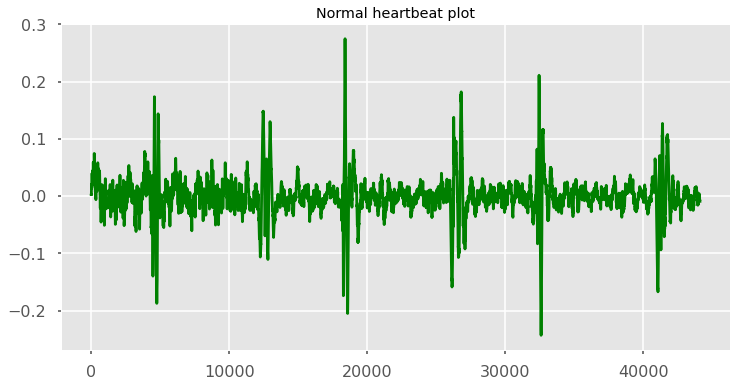

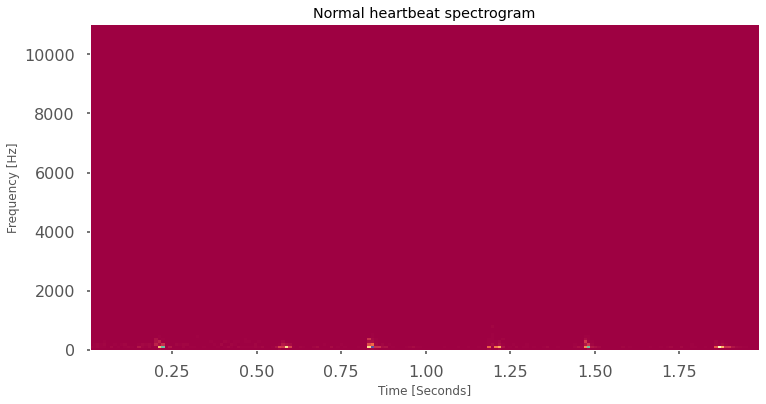

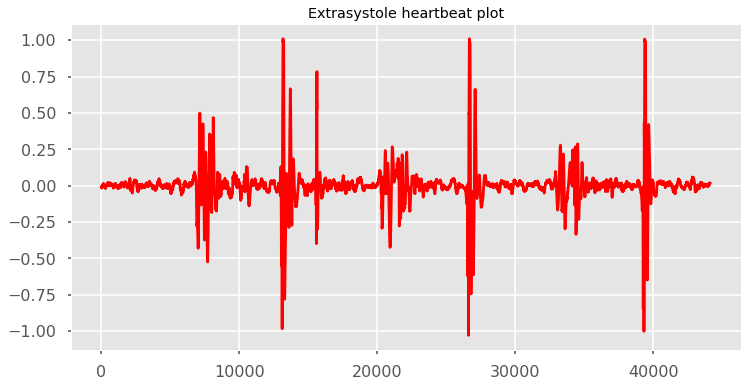

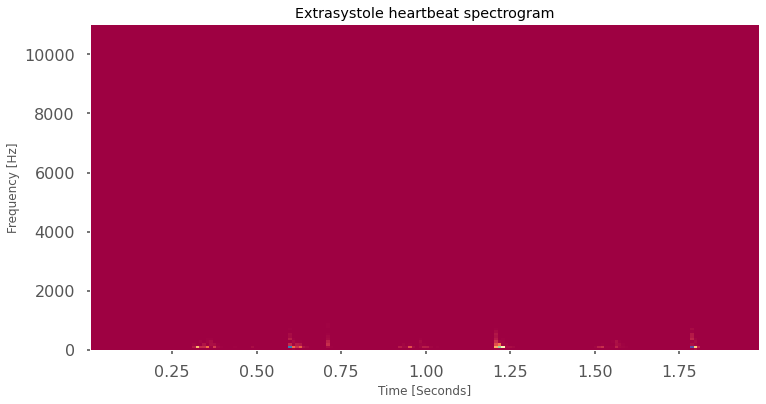

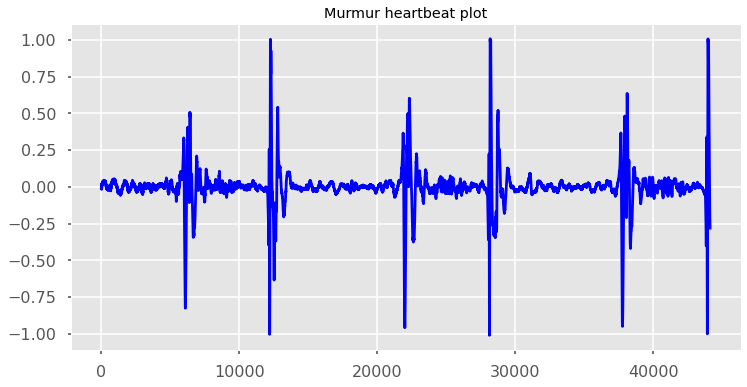

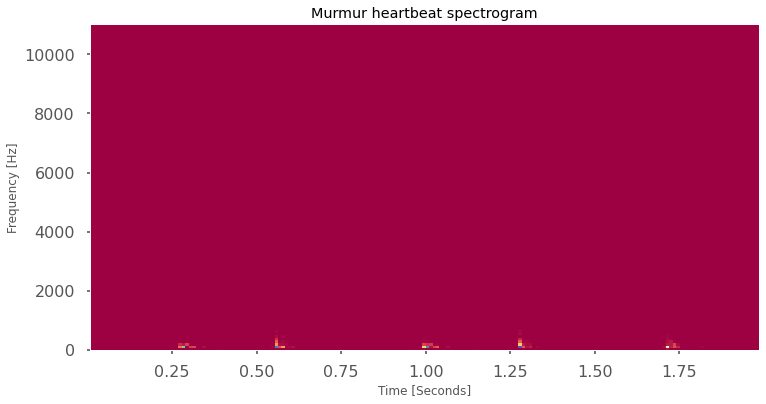

In [211]:
normal       = dataframe[dataframe['class'] == 'Normal'].sample(1)
extrasystole = dataframe[dataframe['class'] == 'Extrastole'].sample(1)
murmur       = dataframe[dataframe['class'] == 'Murmur'].sample(1)

def visualize(data, typename, color, sampling_frequency = 22050):
    # Heartbeat plot
    plt.figure(figsize=(12, 6))
    plt.title(typename + ' heartbeat plot')
    plt.plot(data.values[0], c=color)
    
    # Heartbeat spectrogram
    frequencies, times, Sxx = spectrogram(data.values[0], sampling_frequency)
    plt.figure(figsize=(12, 6))
    plt.title(typename + ' heartbeat spectrogram')
    plt.pcolormesh(times, frequencies, Sxx, cmap='Spectral')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [Seconds]')
    
visualize(normal['data'], "Normal", 'g')
visualize(extrasystole['data'], "Extrasystole", 'r')
visualize(murmur['data'], "Murmur", 'b')

In [212]:
dataframe['data'] = [pywt.dwt(x, 'db4')[0] for x in dataframe['data']]
# dataframe['data'] = [x / max(np.abs(x)) for x in dataframe['data']]
dataframe

,data,class
0,"[0.023944123, 0.02870348, 0.028686967, 0.02940...",Murmur
1,"[-0.0032076945, -0.003983659, -0.003831123, -0...",Murmur
2,"[-0.1973307, -0.21194902, -0.19159752, -0.2066...",Murmur
3,"[0.24697998, 0.24441233, 0.23909551, 0.2422053...",Murmur
4,"[0.2999096, 0.3247753, 0.34972513, 0.3373094, ...",Murmur
...,...,...
665,"[-0.09941711, -0.095870085, -0.08175656, -0.09...",Extrastole
666,"[0.009631607, 0.013634164, 0.0160893, 0.015034...",Extrastole
667,"[-0.06251955, -0.059860557, -0.056059718, -0.0...",Extrastole
668,"[-0.013615055, -0.015399548, -0.017641848, -0....",Extrastole


In [213]:
def extract_features(audio, sample_rate, n_mfcc):
    
    mfccs = librosa.feature.mfcc(y = audio, sr = sample_rate, n_mfcc = n_mfcc)
    mfccsscaled = np.mean(mfccs.T, axis=0)
     
    return mfccsscaled

In [214]:
dataframe['features'] = dataframe['data'].apply(extract_features, sample_rate = 22050, n_mfcc = 100)
dataframe['2dfeatures'] = dataframe['data'].apply(librosa.feature.mfcc, sr = 22050, n_mfcc = 100)
dataframe.head(3)

,data,class,features,2dfeatures
0,"[0.023944123, 0.02870348, 0.028686967, 0.02940...",Murmur,"[-251.79759, 232.64789, -14.14392, 6.7144246, ...","[[-310.5835, -310.29926, -309.7796, -276.65588..."
1,"[-0.0032076945, -0.003983659, -0.003831123, -0...",Murmur,"[-319.85526, 255.92822, -33.756954, -7.5021105...","[[-394.68045, -374.95938, -369.13657, -355.203..."
2,"[-0.1973307, -0.21194902, -0.19159752, -0.2066...",Murmur,"[-187.3124, 244.30977, -17.289858, -1.7678077,...","[[-116.535126, -135.35553, -146.81088, -184.03..."


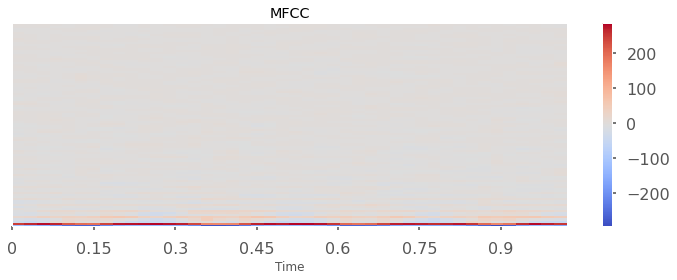

In [215]:
mfccs = librosa.feature.mfcc(y = dataframe['data'][2], sr = 22050, n_mfcc = 100)
mfccsscaled = np.mean(mfccs.T, axis=0)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

In [216]:
X = np.stack(dataframe['data'].values, axis=0)
y = np.stack(dataframe['class'].values, axis=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=17)

## Machine learning methods for classification

## SVM

In [11]:
from sklearn.model_selection import GridSearchCV

clf = SVC(kernel='poly')
grid = GridSearchCV(clf, {'degree': range(1, 11), 'C': np.linspace(1, 3, 200)}, cv = 5, verbose = 1, n_jobs = -1)
SVC_poly = grid.fit(X, y)

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits


In [12]:
print("Лучший показатель в {} достигнут с параметрами {}".format(SVC_poly.best_score_, SVC_poly.best_params_))

Лучший показатель в 0.6880597014925374 достигнут с параметрами {'C': 1.7336683417085426, 'degree': 3}


Посмотрим на точности по степеням

In [13]:
from sklearn.model_selection import cross_val_score

degrees = range(1, 10)
SVC_accs = []

for degree in degrees:
    clf = SVC(kernel='poly', degree = degree, C = SVC_poly.best_params_['C'])
    scores = cross_val_score(clf, X, y, cv = 5)
    SVC_accs.append(scores.mean())

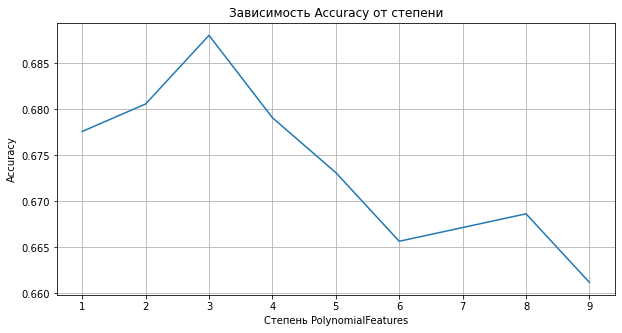

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(degrees, SVC_accs)
plt.xlabel('Степень PolynomialFeatures')
plt.ylabel('Accuracy')
plt.title('Зависимость Accuracy от степени')
plt.grid()
plt.show()

Переберём ядра

In [15]:
kernels = ['linear', 'rbf', 'sigmoid']
clf = SVC()
grid = GridSearchCV(clf, {'kernel': kernels, 'C': np.linspace(0.5, 3, 200)}, cv = 5, verbose = 1, n_jobs = -1)
SVC_any = grid.fit(X, y)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


In [16]:
print("Лучший показатель в {} достигнут с параметрами {}"
      .format(SVC_any.best_score_, SVC_any.best_params_))

Лучший показатель в 0.6805970149253733 достигнут с параметрами {'C': 2.409547738693467, 'kernel': 'rbf'}


## Random Forest

In [17]:
# Creating the dependent variable class
factor = pd.factorize(dataframe['class'])
dataframe['numclass'] = factor[0]
definitions = factor[1]
print(dataframe.numclass.head())
print(definitions)

0    0
1    0
2    0
3    0
4    0
Name: numclass, dtype: int64
Index(['Murmur', 'Normal', 'Extrastole'], dtype='object')


In [18]:
Xf = np.stack(dataframe['features'].values, axis=0)
yf = np.stack(dataframe['numclass'].values, axis=0)

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier(n_jobs = -1, random_state = 17)
grid = GridSearchCV(clf, {'n_estimators': range(1, 101)}, cv = 5, verbose = 1, n_jobs = -1)

forest = grid.fit(Xf, yf)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [20]:
print("Лучший показатель в {} достигнут с числом деревьев {}".format(forest.best_score_, forest.best_params_['n_estimators']))

Лучший показатель в 0.7 достигнут с числом деревьев 92


In [21]:
from sklearn.metrics import classification_report
target_names = ['Murmur', 'Normal', 'Extrastole']
print("Accuracy is", forest.best_score_, "\n")

#print(classification_report(yf, forest_predictions, target_names=target_names))

Accuracy is 0.7 



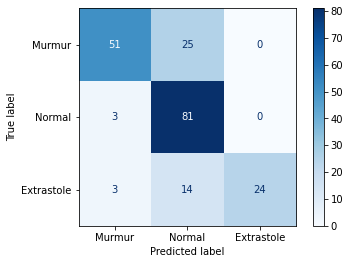

In [22]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split

Xf_train, Xf_test, yf_train, yf_test = train_test_split(Xf, yf, test_size = 0.3, random_state=42)

clf = RandomForestClassifier(n_estimators = 87, n_jobs = -1, random_state = 17)
clf.fit(Xf_train, yf_train)

disp = plot_confusion_matrix(clf, Xf_test, yf_test,
                             cmap = plt.cm.Blues,
                             display_labels = definitions)

## kNN

In [23]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_jobs=-1)
grid = GridSearchCV(clf, {'n_neighbors': range(1, 100)}, cv=5, verbose=1, n_jobs = -1)
knn = grid.fit(X, y)

Fitting 5 folds for each of 99 candidates, totalling 495 fits


In [24]:
def draw_chart(clf, param, steps, x_label = "Значение параметра", y_label = "Accuracy", title = "График зависимости точности от выбранного параметра"):
    df = pd.DataFrame(clf.cv_results_)
    means = df['mean_test_score']
    stds = df['std_test_score']
    
    # Устанавливаем размер графика, наносим средние значения точности кросс-валидации и накидываем св. квадр. отклонение
    plt.figure(figsize=(15, 7))
    plt.plot(df['params'].apply(lambda x: x[param]), means)
    plt.fill_between(range(1, len(means) + 1), means + stds, means - stds, alpha = 0.5)
    
    # наносим значения на оси
    plt.xlim(1, len(means) + 1)
    plt.ylim(np.min(means - stds) - 0.05, np.max(means + stds) + 0.05)
    
    # Устанавливаем шаги, наносим сетку и подписываем оси с графиком
    plt.xticks(steps)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid()
    plt.show()

In [25]:
print("Лучший показатель в {} достигнут с параметрами {}"
      .format(knn.best_score_, knn.best_params_))

Лучший показатель в 0.6791044776119403 достигнут с параметрами {'n_neighbors': 57}


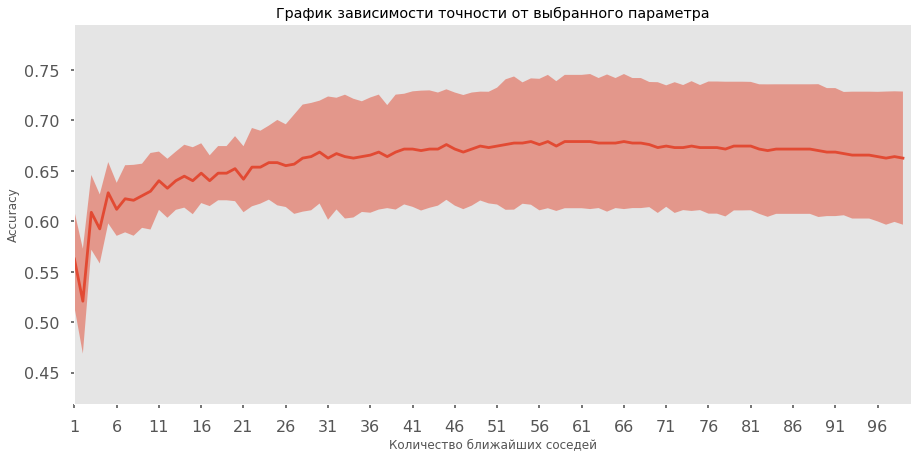

In [47]:
draw_chart(knn, 'n_neighbors', range(1, 100, 5), 'Количество ближайших соседей')

In [27]:
from sklearn.metrics import classification_report

best_neigh = KNeighborsClassifier(n_neighbors = 4)
best_neigh.fit(X_train, y_train)
best_knn_predictions = best_neigh.predict(X_test)

print(classification_report(y_test, best_knn_predictions))

              precision    recall  f1-score   support

  Extrastole       0.79      0.81      0.80        32
      Murmur       0.81      0.91      0.86        56
      Normal       0.86      0.78      0.82        80

    accuracy                           0.83       168
   macro avg       0.82      0.83      0.82       168
weighted avg       0.83      0.83      0.83       168



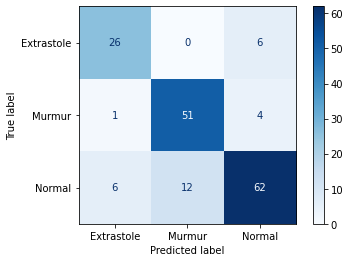

In [28]:
from sklearn.metrics import plot_confusion_matrix

disp = plot_confusion_matrix(best_neigh, X_test, y_test,
                                 cmap=plt.cm.Blues)

In [217]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

X = np.array(dataframe['2dfeatures'].tolist())
y = np.array(dataframe['class'].tolist())

le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 

from sklearn.model_selection import train_test_split 

x_pre, x_test, y_pre, y_test = train_test_split(X, yy, test_size = 0.2, random_state = 17)
x_train, x_valid, y_train, y_valid = train_test_split(x_pre, y_pre, test_size = 0.25, random_state = 17)

In [218]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn import metrics 

num_rows = 100
num_columns = x_train.size // num_rows // x_train.shape[0]
num_channels = 1

x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)
x_valid = x_valid.reshape(x_valid.shape[0], num_rows, num_columns, num_channels)

num_labels = yy.shape[1]
filter_size = 2

# Construct model 
model = Sequential()
model.add(Conv2D(filters=8, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=16, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax'))

In [219]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 99, 43, 8)         40        
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 49, 21, 8)         0         
_________________________________________________________________
dropout_69 (Dropout)         (None, 49, 21, 8)         0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 48, 20, 16)        528       
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 24, 10, 16)        0         
_________________________________________________________________
dropout_70 (Dropout)         (None, 24, 10, 16)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 23, 9, 32)       

In [173]:
#from keras.utils.vis_utils import plot_model

#plot_model(model, show_shapes=True, show_layer_names=True)

In [220]:
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 

num_epochs = 200
num_batch_size = 64

start = datetime.now()

hist = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_valid, y_valid), verbose=1)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/200
7/7 [==============================] - 1s 45ms/step - loss: 2.0055 - accuracy: 0.3955 - val_loss: 0.9750 - val_accuracy: 0.5373
Epoch 2/200
7/7 [==============================] - 0s 43ms/step - loss: 1.5588 - accuracy: 0.4527 - val_loss: 0.9834 - val_accuracy: 0.5373
Epoch 3/200
7/7 [==============================] - 0s 42ms/step - loss: 1.2225 - accuracy: 0.4005 - val_loss: 1.0030 - val_accuracy: 0.4254
Epoch 4/200
7/7 [==============================] - 0s 40ms/step - loss: 1.1645 - accuracy: 0.4179 - val_loss: 0.9553 - val_accuracy: 0.5821
Epoch 5/200
7/7 [==============================] - 0s 39ms/step - loss: 1.0698 - accuracy: 0.4900 - val_loss: 0.9914 - val_accuracy: 0.4403
Epoch 6/200
7/7 [==============================] - 0s 43ms/step - loss: 1.0522 - accuracy: 0.4677 - val_loss: 0.9876 - val_accuracy: 0.3881
Epoch 7/200
7/7 [==============================] - 0s 43ms/step - loss: 0.9883 - accuracy: 0.5398 - val_loss: 0.9440 - val_accuracy: 0.6418
Epoch 8/200
7/7 [===

7/7 [==============================] - 0s 43ms/step - loss: 0.6780 - accuracy: 0.7562 - val_loss: 0.7140 - val_accuracy: 0.7687
Epoch 60/200
7/7 [==============================] - 0s 43ms/step - loss: 0.6798 - accuracy: 0.7139 - val_loss: 0.7209 - val_accuracy: 0.7761
Epoch 61/200
7/7 [==============================] - 0s 43ms/step - loss: 0.6504 - accuracy: 0.7512 - val_loss: 0.7142 - val_accuracy: 0.7388
Epoch 62/200
7/7 [==============================] - 0s 41ms/step - loss: 0.6532 - accuracy: 0.7438 - val_loss: 0.7187 - val_accuracy: 0.7612
Epoch 63/200
7/7 [==============================] - 0s 40ms/step - loss: 0.6796 - accuracy: 0.7289 - val_loss: 0.7109 - val_accuracy: 0.7687
Epoch 64/200
7/7 [==============================] - 0s 41ms/step - loss: 0.6658 - accuracy: 0.7438 - val_loss: 0.7128 - val_accuracy: 0.7537
Epoch 65/200
7/7 [==============================] - 0s 42ms/step - loss: 0.6514 - accuracy: 0.7438 - val_loss: 0.7134 - val_accuracy: 0.7761
Epoch 66/200
7/7 [========

7/7 [==============================] - 0s 43ms/step - loss: 0.5958 - accuracy: 0.7612 - val_loss: 0.6515 - val_accuracy: 0.7910
Epoch 118/200
7/7 [==============================] - 0s 41ms/step - loss: 0.5881 - accuracy: 0.7886 - val_loss: 0.6386 - val_accuracy: 0.7985
Epoch 119/200
7/7 [==============================] - 0s 39ms/step - loss: 0.5783 - accuracy: 0.7861 - val_loss: 0.6170 - val_accuracy: 0.7910
Epoch 120/200
7/7 [==============================] - 0s 43ms/step - loss: 0.6380 - accuracy: 0.7438 - val_loss: 0.6427 - val_accuracy: 0.7985
Epoch 121/200
7/7 [==============================] - 0s 43ms/step - loss: 0.6147 - accuracy: 0.7413 - val_loss: 0.6467 - val_accuracy: 0.7910
Epoch 122/200
7/7 [==============================] - 0s 39ms/step - loss: 0.5723 - accuracy: 0.7687 - val_loss: 0.6490 - val_accuracy: 0.7687
Epoch 123/200
7/7 [==============================] - 0s 43ms/step - loss: 0.5695 - accuracy: 0.7861 - val_loss: 0.6366 - val_accuracy: 0.7910
Epoch 124/200
7/7 [=

Epoch 175/200
7/7 [==============================] - 0s 49ms/step - loss: 0.5050 - accuracy: 0.8010 - val_loss: 0.5641 - val_accuracy: 0.8209
Epoch 176/200
7/7 [==============================] - 0s 46ms/step - loss: 0.5225 - accuracy: 0.7910 - val_loss: 0.5528 - val_accuracy: 0.8209
Epoch 177/200
7/7 [==============================] - 0s 50ms/step - loss: 0.5050 - accuracy: 0.8159 - val_loss: 0.5555 - val_accuracy: 0.8209
Epoch 178/200
7/7 [==============================] - 0s 49ms/step - loss: 0.5165 - accuracy: 0.7985 - val_loss: 0.5662 - val_accuracy: 0.8284
Epoch 179/200
7/7 [==============================] - 0s 44ms/step - loss: 0.4963 - accuracy: 0.8060 - val_loss: 0.5572 - val_accuracy: 0.8284
Epoch 180/200
7/7 [==============================] - 0s 40ms/step - loss: 0.5092 - accuracy: 0.8060 - val_loss: 0.5467 - val_accuracy: 0.8209
Epoch 181/200
7/7 [==============================] - 0s 42ms/step - loss: 0.4772 - accuracy: 0.8209 - val_loss: 0.5482 - val_accuracy: 0.8134
Epoch 

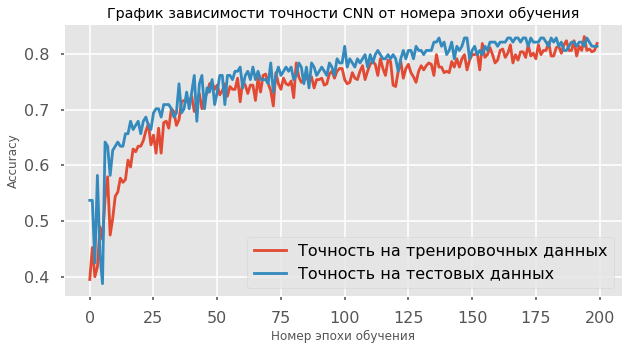

In [226]:
accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']

plt.figure(1, figsize=(10, 5))
plt.title('График зависимости точности CNN от номера эпохи обучения')
plt.plot(accuracy, label="Точность на тренировочных данных")
plt.plot(val_accuracy, label="Точность на тестовых данных")
plt.ylabel('Accuracy')
plt.xlabel('Номер эпохи обучения')
plt.legend()

plt.show()

In [227]:
from sklearn.metrics import classification_report

test_preds = model.predict_classes(x_test, batch_size = 64, verbose=0)
rounded_labels = np.argmax(y_test, axis=1)

print("Accuracy for test = {}\n".format(accuracy_score(rounded_labels, test_preds)))
print(classification_report(rounded_labels, test_preds, target_names=['Extrastole', 'Murmur', 'Normal']))

Accuracy for test = 0.8059701492537313

              precision    recall  f1-score   support

  Extrastole       1.00      0.43      0.61        23
      Murmur       0.97      0.73      0.84        49
      Normal       0.71      1.00      0.83        62

    accuracy                           0.81       134
   macro avg       0.90      0.72      0.76       134
weighted avg       0.86      0.81      0.80       134



/usr/local/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


## 3. Convolutional Neural Network (CNN)

In [229]:
import time
start = time.time() * 1000
model.predict(x_test)
end = time.time() * 1000
total = end - start
print("Total prediction time in ms for %d samples: %f" % (len(X_test), total))
print("Average prediction time in ms for 1 example: %f" % (total/len(X_test)))

Total prediction time in ms for 168 samples: 55.463135
Average prediction time in ms for 1 example: 0.330138
